In [1]:
import sys
sys.path.append("..")

In [2]:
import load1_mix
import torch
import os
import time
import torch.nn as nn
from torchvision import transforms,models
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils import data
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from fast_adv.attacks import DDN, CarliniWagnerL2
from fast_adv.utils import requires_grad_, l2_norm
import matplotlib.pyplot as plt
print(os.getcwd())

D:\Passive None-Line-of-Sight Recognition\Attacks


In [3]:
transform = transforms.ToTensor()
file_root=r'../'
test_name=r'../data\Mixed_setup_Measurement_Split\test_mea'
#name=r'D:\data_and_program\32_40\new_test'
save_path = 'processed'
if not os.path.exists(save_path):
    os.makedirs(save_path)

test_dataset = load1_mix.MNIST(root=file_root, \
                           test_file=os.path.join(save_path,test_name.split('\\')[-1]+r'.pt'), \
                           filename=test_name,
                           train=False,transform=transform ,download=True)

In [4]:
train_batch_size = 64
test_batch_size = 16
learning_rate = 0.01
num_epoches = 20
torch.manual_seed(42)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=test_batch_size,shuffle=False)

In [5]:
examples = enumerate(test_loader)
batch_idx, (example_data_ori,example_data, example_targets) = next(examples)
#print(next(examples)[1][0])
#print(example_data[0][0].shape)

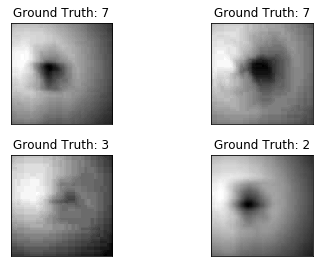

In [6]:
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0],cmap='gray')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

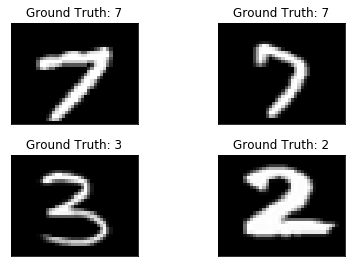

In [7]:
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.tight_layout()
    plt.imshow(example_data_ori[i][0],cmap='gray')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [8]:
torch.manual_seed(42)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_path=r'logs/mixed_all_canshu_resnet18_28.pkl'
#model_path = r'C:/Users/Qxslab/Desktop/auto_generation/models/sy_Simple.pkl'

In [9]:
print('Loading model')
model=models.resnet18(pretrained=True)
stride,kernel_size,padding,bias=model.conv1.stride,model.conv1.kernel_size,model.conv1.padding,model.conv1.bias
model.conv1=nn.Conv2d(1,64,kernel_size,stride,padding,bias=bias)
model.avgpool=nn.AvgPool2d(4,stride=1)
print(model.avgpool)
model.fc = nn.Linear(512,10)
#实例化模型
model.to(device)
model.load_state_dict(torch.load(model_path))
#model.load_state_dict({k.replace('module.',''):v for k,v in torch.load(model_path)['state_dict'].items()})
model.eval().to(device)
requires_grad_(model, False)

Loading model
AvgPool2d(kernel_size=4, stride=1, padding=0)


tensor([7, 7, 3, 2, 8, 6, 1, 3, 3, 7, 4, 8, 2, 6, 8, 4], device='cuda:0')

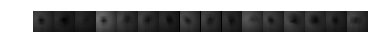

In [10]:
x_o,x, y = next(iter(test_loader))
x = x.to(device)
y = y.to(device)

plt.imshow(make_grid(x.cpu(), nrow=16).permute(1,2,0))
plt.axis('off');
y

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')

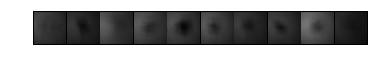

In [11]:
def random_split(dataset,ratio=0.8):
    train = []
    test = []
    for i in range(10):
        np.random.seed(42)
        data = torch.utils.data.Subset(dataset, (dataset.test_labels == i).nonzero().t()[0].tolist())
        train_size = 1
        test_size = len(data) - train_size
        train_db, val_db = torch.utils.data.random_split(data, [train_size, test_size])
        train.append(train_db)
        test.append(val_db)
    train_data= torch.utils.data.ConcatDataset(train)
    test_data=torch.utils.data.ConcatDataset(test)
    return train_data,test_data
torch.manual_seed(42)
train_data,test_data=random_split(test_dataset)
test_loader1 = torch.utils.data.DataLoader(dataset=train_data,batch_size=10,shuffle=False)
x_ori,x,y= next(iter(test_loader1))
x = x.to(device)
y = y.to(device)

plt.imshow(make_grid(x.cpu(), nrow=16).permute(1,2,0))
plt.axis('off');
y

Running DDN 100 attack
Completed in 3.65s


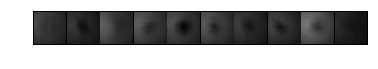

In [12]:
print('Running DDN 100 attack')
attacker = DDN(steps=100, device=device)
start = time.time()
ddn_atk = attacker.attack(model, x, labels=y, targeted=False)
ddn_time = time.time() - start
print('Completed in {:.2f}s'.format(ddn_time))
plt.imshow(make_grid(ddn_atk.cpu(), nrow=16).permute(1,2,0))
plt.axis('off');

In [13]:
pred_ddn = model(ddn_atk).argmax(dim=1).cpu()
acc= (pred_ddn != y.cpu()).float().mean().item()
l2=(l2_norm(ddn_atk - x)/torch.stack([(i.max()-i.min())*np.sqrt(x.shape[2]) for i in x])).mean().item()
print(acc)
print(l2)

1.0
0.025213757529854774


In [14]:
save_path=r'./mixed/resnet/secondary_surface'
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [16]:
print('Running DDN 100 attack on total_data')
a=[]
eval_acc = 0
eval_l2=0
start = time.time()
for batch, (x_ori,x,y) in enumerate(test_loader):
    x = x.to(device)
    y = y.to(device)
    attacker = DDN(steps=100, device=device)
    ddn_atk = attacker.attack(model, x, labels=y, targeted=False)
    for i in range(len(ddn_atk.cpu())):
        save_image(ddn_atk.cpu()[i],os.path.join(save_path,str(i+1+batch*test_batch_size)+'_'+str(y.cpu()[i].item())+'.png'))
    pred_ddn = model(ddn_atk).argmax(dim=1).cpu()
    acc= (pred_ddn != y.cpu()).float().mean().item()
    l2=(l2_norm(ddn_atk - x)/torch.stack([(i.max()-i.min())*np.sqrt(x.shape[2]) for i in x])).mean().item()
    #l2=l2_norm(ddn_atk - x).mean().item()
    eval_acc += acc
    eval_l2 +=l2
    a.append(acc)
ddn_time = time.time() - start    
print('Completed in {:.2f}s'.format(ddn_time))    
print(eval_acc/len(test_loader))
print(eval_l2/len(test_loader))

Running DDN 100 attack on total_data
Completed in 8419.84s
1.0
0.029986096733805544
